# Header

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as math
import janitor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import os

exec(open("../header.py").read())

Header initialized


# Import

In [3]:
threshold = 40

In [4]:
raw_train_data = pd.read_csv(processed_root("03-bag-of-words/threshold-"+str(threshold)+"/bow_train_data.csv"))
raw_val_data = pd.read_csv(processed_root("03-bag-of-words/threshold-"+str(threshold)+"/bow_val_data.csv"))
raw_test_data = pd.read_csv(processed_root("03-bag-of-words/threshold-"+str(threshold)+"/bow_test_data.csv"))

In [5]:
X_train = raw_train_data\
    .drop(['poetry_text', 'poetry_author'], axis = 1)
X_val = raw_val_data\
    .drop(['poetry_text', 'poetry_author'], axis = 1)
y_train = raw_train_data['poetry_author']
y_val = raw_val_data['poetry_author']

In [6]:
len(X_train.columns)

1897

# Evaluate and Tune

In [38]:
def tuning_loop(max_depth_choices):
    
    train_accuracies = []
    val_accuracies = []

    for max_depth in max_depth_choices:
        rf = RandomForestClassifier(max_depth = max_depth, class_weight = "balanced")
        rf.fit(X_train, y_train)
        # Training
        y_pred_train = rf.predict(X_train)
        train_accuracy = np.mean(y_pred_train == y_train) * 100
        train_accuracies.append(train_accuracy)

        # Validation
        y_pred_val = rf.predict(X_val)
        val_accuracy = np.mean(y_pred_val == y_val) * 100
        val_accuracies.append(val_accuracy)
        
    return train_accuracies, val_accuracies

In [ ]:
max_depth_choices = [(i+1)*5 for i in range(30)]
train_accuracies, val_accuracies = tuning_loop(max_depth_choices)

In [55]:
def plot_results(md, train, val):
    fig, ax = plt.subplots()
    ax.plot(md, train, label = "Train")
    ax.plot(md, val, label = "Validation")
    ax.set_title("Random Forest Accuracy versus Max Depth")
    ax.set_xlabel("Max Depth")
    ax.set_ylabel("Accuracy (%)")
    ax.legend()
    
    print("Maximum validation accuracy, %.2f%% found at max depth of %d."\
      %(max(val), md[np.argmax(val)]))

Maximum validation accuracy, 57.48% found at max depth of 20.


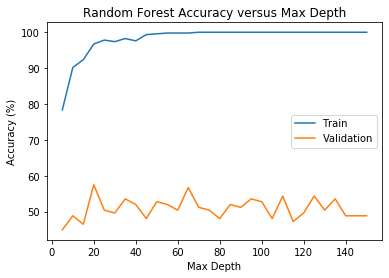

In [56]:
plot_results(max_depth_choices, train_accuracies, val_accuracies)

## Second tune

In [45]:
max_depth_choices2 = [i for i in range(15,26)]
train_accuracies2, val_accuracies2 = tuning_loop(max_depth_choices2)

Maximum validation accuracy, 57.48% found at max depth of 24.


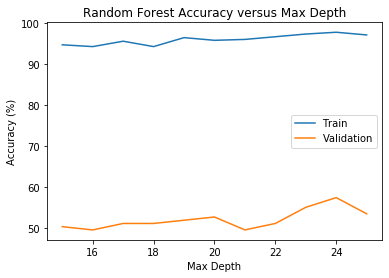

In [57]:
plot_results(max_depth_choices2, train_accuracies2, val_accuracies2)